In [1]:

import torch
from torch import nn
from icecream import ic
from torch.optim import Adam
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset, random_split


# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(str(device))

N = 4  # number of images in whole picture
L_x = 5  # x and y pixel dims
L_y = 5
N_i = L_x * L_y
N_h = 256  # number of hidden units
N_o = 1  # number of output units


class IonImagesDataset(Dataset):
    def __init__(self, file_path):
        loaded_data_dict = torch.load(file_path)  # loading dataset into dataloader

        self.images = loaded_data_dict[
            "images"
        ]  # creating of 2 datasents of imgages and keys to them
        self.labels = loaded_data_dict["labels"]

    def __len__(self):
        return len(self.images)  # just return len function

    def __getitem__(self, idx):
        image_tensor = self.images[idx]  # Add a channel dimension
        label_tensor = self.labels[idx]  # Repeat the label for each ion position
        return image_tensor, label_tensor


file_path_pt = "binary\labels_and_images.pt"


dataset = IonImagesDataset(file_path_pt)
halfpi_dataset = IonImagesDataset(file_path_pt)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print(
    f"Train size: {train_size}, Validation size: {val_size}"
)  # Print the sizes of subsets

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(
    f"Train dataset size: {len(train_dataset)}"
)  # Print the size of the train_dataset
print(
    f"Validation dataset size: {len(val_dataset)}"
)  # Print the size of the val_dataset

# Create DataLoaders for the training and validation datasets
batch_size = min(1000, len(train_dataset))  # or choose a smaller value
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

halfpi_loader = DataLoader(
    halfpi_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)


class IndexDependentDense(nn.Module):
    def __init__(self, N, N_i, N_o, activation=nn.ReLU()):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.activation = activation
        self.register_parameter(
            "W", nn.Parameter(torch.empty(self.N, self.N_i, self.N_o))
        )
        self.register_parameter("b", nn.Parameter(torch.empty(self.N, self.N_o)))

        self._reset_parameters()

        pass

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, x):
        y = torch.einsum("nij,...ni->...nj", self.W, x) + self.b
        if self.activation is not None:
            return self.activation(y)
        else:
            return y

    pass


# ---------------------------------------------------------------------------------------------


class Encoder(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = IndexDependentDense(N, N_i, N_o, activation=nn.ReLU())
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class Classifier(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o
        self.dense = IndexDependentDense(N, N_i, N_o, activation=None)
        pass

    def forward(self, x):
        y = self.dense(x)
        y = torch.sigmoid(y)  # Apply sigmoid activation here
        return y

    pass


# ---------------------------------------------------------------------------------------------


class SharedEncoder(nn.Module):
    def __init__(self, N, N_i, N_o):
        super().__init__()

        self.N = N
        self.N_i = N_i
        self.N_o = N_o

        self.dense = nn.Linear(N_i, N_o)
        pass

    def forward(self, x):
        y = self.dense(x)
        return y

    pass


# ---------------------------------------------------------------------------------------------


class MultiIonReadout(nn.Module):
    def __init__(self, encoder, shared_encoder, classifier):
        super().__init__()

        self.encoder = encoder
        self.shared_encoder = shared_encoder
        self.classifier = classifier

    def forward(self, x):
        y = x.reshape(*x.shape[:-2], -1).to(torch.float32)
        y1 = self.encoder(y)
        y2 = self.shared_encoder(y)
        y_concat = torch.cat([y1, y2], dim=-1)
        y = self.classifier(y_concat)
        return y

    def bceloss(self, X, y):
        return F.binary_cross_entropy(self(X), y)

    @staticmethod
    def _accuracy(y_pred, y_true):
        mod_y_pred = (y_pred > 0.5).to(torch.float32)
        accuracy = (y_true == mod_y_pred).to(dtype=torch.float32).mean()
        return accuracy * 100

    def accuracy(self, x, y):
        return self._accuracy(self(x), y)


# ---------------------------------------------------------------------------------------------

cpu
Train size: 8000, Validation size: 2000
Train dataset size: 8000
Validation dataset size: 2000


In [2]:
device = torch.device("cpu")
# model 
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)


model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
 Epoch 100/100, Training Loss = 0.20414437353610992, Val Loss = 0.22793082147836685, Val Acc = 92.5374984741211

In [3]:
device = torch.device("cpu")
# model 
encoder = Encoder(N, N_i, N_h)
shared_encoder = SharedEncoder(N, N_i, N_h)
classifier = Classifier(N, N_h * 2, N_o)
model = MultiIonReadout(encoder, shared_encoder, classifier)


model = model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(pytorch_total_params2)

N_epochs = 100
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
schedule_params = {"factor": 1}
schedule = lr_scheduler.ConstantLR(optimizer, **schedule_params)
log_every = 1

# Training loop
for epoch in range(N_epochs):

    total_train_loss = 0
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = model.bceloss(inputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation loop
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = model.bceloss(inputs, labels)
            accuracy = model.accuracy(inputs, labels)
            total_loss += loss.item()
            total_accuracy += accuracy.item()

        avg_loss = total_loss / len(val_loader)
        avg_accuracy = total_accuracy / len(val_loader)

    print(
        "\r Epoch {}/{}, Training Loss = {}, Val Loss = {}, Val Acc = {}".format(
            epoch + 1, N_epochs, loss.item(), avg_loss, avg_accuracy
        ),
        end="",
    )

# torch.save(model.state_dict(), "golden_WandB_n.pth")

35332
35332
 Epoch 100/100, Training Loss = 0.23857994377613068, Val Loss = 0.22776749730110168, Val Acc = 92.48749923706055

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms

In [6]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            #torch.nn.Linear(800, 256),
            #torch.nn.ReLU(),
            #torch.nn.Linear(256, 128),
            #torch.nn.ReLU(),
            torch.nn.Linear(100, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 4)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 100),
            torch.nn.ReLU(),
            #torch.nn.Linear(128, 256),
            #torch.nn.ReLU(),
            #torch.nn.Linear(256,  800),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [ ]:
for inputs, labels in train_loader:
    

In [16]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 256,
                                     shuffle = True)

In [15]:
dataset

In [18]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for (image,_) in loader:
       
      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 100)
       
      # Output of Autoencoder
      reconstructed = model(image)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, image)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, image, reconstructed))

In [19]:
losses_np = torch.stack(losses).detach().numpy()

In [20]:
losses_np

array([23.888527, 23.865366, 24.446918, 24.997305, 24.892462, 21.49004 ,
       24.088594, 23.627617, 23.087305, 23.129454, 22.02746 , 23.360937,
       23.769531, 24.73246 , 23.174257, 22.871056, 23.352774, 24.954414,
       23.480976, 25.069492, 24.715937, 24.318087, 24.723398, 24.828476,
       23.462852, 23.979921, 24.605234, 23.38039 , 23.543242, 22.715782,
       23.271368, 20.146563, 22.858126, 24.713282, 24.40918 , 24.370743,
       22.504179, 23.628633, 22.872265, 23.766132, 21.471563, 23.434765,
       23.628124, 24.388672, 23.84668 , 24.36371 , 23.73375 , 23.862383,
       24.563828, 24.755938, 22.965782, 22.697891, 24.630077, 25.699726,
       23.90496 , 23.084257, 23.128712, 24.971563, 25.454727, 21.907343,
       23.265   , 23.133827, 24.212734, 22.914375, 24.45043 , 24.471485,
       23.520195, 23.466875, 25.355742, 23.433945, 23.380508, 23.17707 ,
       23.62414 , 24.261446, 23.123125, 24.43293 , 23.888203, 24.04629 ,
       23.135977, 22.172852, 25.709883, 22.847305, 

In [21]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

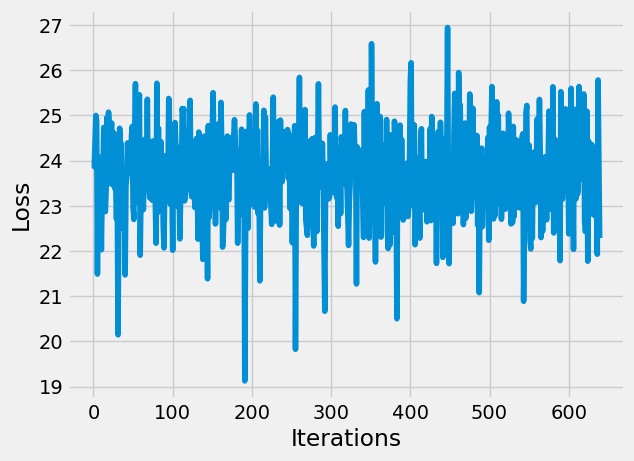

In [22]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses_np)

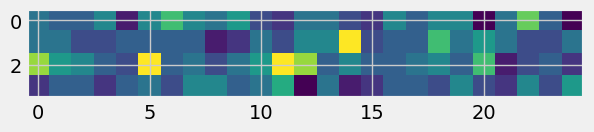

In [23]:
for i, item in enumerate(image):
  # Reshape the array for plotting
  item = item.reshape(-1, 4, 25)
  plt.imshow(item.detach().numpy()[0])

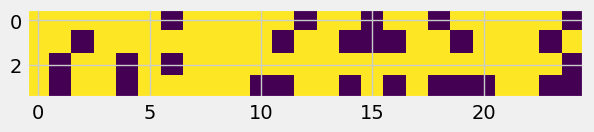

In [24]:
for i, item in enumerate(reconstructed):
  item = item.reshape(-1, 4, 25)
  plt.imshow(item.detach().numpy()[0])

In [52]:
simplified_data = []
truth = []
tuple_simplified = []
for (image,label) in dataset:
    image = image.reshape(-1, 100)
    encoded_data=model.encoder(image)
    simplified_data.append(encoded_data.detach().numpy())
    truth.append(label)
    tuple_simplified.append((encoded_data,label))

In [26]:
len(simplified_data)

10000

In [53]:
Y = torch.stack(truth).detach().numpy()

In [54]:
Y = Y[:,:,0]

In [91]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [70]:
X = np.vstack(simplified_data)

In [73]:
X.shape

(10000, 4)

In [74]:
Y.shape

(10000, 4)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [86]:
forest = RandomForestClassifier()
multi_target_forest = MultiOutputClassifier(forest, n_jobs=2).fit(X_train, y_train)

In [87]:
multi_target_forest.score(X_train, y_train)

0.99875

In [88]:
multi_target_forest.score(X_test, y_test)

0.127

In [93]:
raw_preds = np.clip(X,0,1)

In [94]:
accuracy_score(raw_preds,Y)

0.0594